# TSA Datascience 2022 - 23 #

using GTFS data that is available for most major cities

In [1]:
import csv
from matplotlib import pyplot as plt

with open('lvb_gtfs/stops.txt', newline='', encoding = "utf-8") as f:
    reader = csv.reader(f)
    stops_file = list(reader)
    stops_file.pop(0)

stops_dict = {}

for row in stops_file:
    stop_id = row[0]
    lang = row[2]
    lat = row[3]
    stops_dict[stop_id] = [lang, lat]



# print(data[:100])

ModuleNotFoundError: No module named 'matplotlib'

## plot all stops as points on a coordinate plane ##

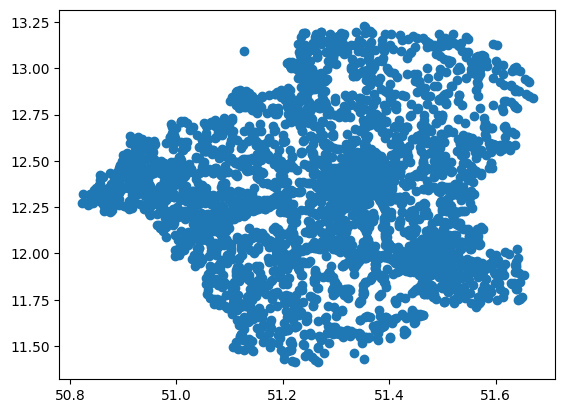

In [ ]:
x = list(zip(*stops_file))[2]
x_coords = []
for c in x:
    a = float(c)
    x_coords.append(a)


y = list(zip(*stops_file))[3]
y_coords = []
for c in y:
    a = float(c)
    y_coords.append(a)

# print(x[0:100])
# print(y[0:100])

plt.scatter(x_coords,y_coords)
plt.show()

Um Routen mit einzubeziehen sind 3 Dateien nötig:
- stops
- stop_times

stops = [stop_id, lat, long]
stop_times = [trip_id, stop_id]



## plot all Routes as connected line graph ##

In [ ]:
%pip install more_itertools
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'e:\datascience\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'e:\datascience\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
from ftplib import all_errors
import copy

with open('lvb_gtfs/stop_times.txt', newline='', encoding = "utf-8") as f:
    reader = csv.reader(f)
    stop_times_file = list(reader)
    stop_times_file.pop(0)

# dict that collects {trip_id : [stop_1, stop_2, stop_3, ...]}
all_routes = {}
routenumber = 56389

# set a default for each key in the dict
for i in range (routenumber + 1):
    all_routes.setdefault(i, [])


former_trip_id = 1
for stop_times_row in stop_times_file:

    current_trip_id = int(stop_times_row[0])
    stop_id_from_stop_times = stop_times_row[3]

    # do everything in increments of one route
    # take the entry for each route and take all of the others
    if (current_trip_id == former_trip_id):
        all_routes[current_trip_id].append(stop_id_from_stop_times)
    else:
        former_trip_id += 1
        all_routes[current_trip_id].append(stop_id_from_stop_times)


all_routes_copy = copy.deepcopy(all_routes) # copy cuz of changing size
checklist = []

for key, value in all_routes_copy.items():
    if value in checklist:
        del all_routes[key]
    else:
        checklist.append(value)


    


FileNotFoundError: [Errno 2] No such file or directory: 'lvb_gtfs/stop_times.txt'

Replace every stop with its lat, long coordinates

In [ ]:
from tqdm import tqdm
all_coords = [] # 2d list of all coordinate pairs (makes it 3d)


for row in tqdm(all_routes.items()): # loop over every route

    coords_list = []
    for stop_id in row[1]: # get all stops from route
        coordinates = stops_dict[stop_id] # read coordinates from stops
        coords_list.append(coordinates)


    all_coords.append(coords_list)


print(all_coords[0:3])

all_coords = all_coords[1:] # remove first entry

100%|██████████| 6031/6031 [00:00<00:00, 172329.12it/s]

[[], [['51.396257', '12.219626'], ['51.370177', '12.217191'], ['51.371446', '12.199410'], ['51.370311', '12.197865'], ['51.361179', '12.210557'], ['51.352536', '12.206017'], ['51.348831', '12.206060'], ['51.351904', '12.220850']], [['51.396257', '12.219626'], ['51.370177', '12.217191'], ['51.371446', '12.199410'], ['51.370311', '12.197865'], ['51.361179', '12.210557'], ['51.352536', '12.206017'], ['51.353448', '12.207876']]]


Plot the results

In [ ]:

plt.figure(dpi=3000)

counter = 0
for line in all_coords:
    linenumber = counter
    counter += 1

    #print(linenumber, line[1])

    x, y = zip(*(line))

    x = list(map(float,x)) # convert to float
    y = list(map(float,y)) # convert to float

    plt.plot(x,y,label = linenumber)

plt.yticks([11.25,13.25])
plt.xticks([50.8,51.8])
#plt.legend()
plt.savefig("plot")
plt.show()



visualize reachability of each spot

This is done by drawing a circle around each stop with a variable radius

In [ ]:
# find neighbours for every stop, convert to dict

from tracemalloc import start
import networkx as nx
import csv

maxstopid = 8098205 # highest number that stop_id ever reaches (for dict init)
maxlinenumber = len(stop_times_file) 

# set default for every entry to be a list, dict throws key error if you try to append to a non existing key
stop_times_dict = {}
for i in range(maxstopid + 1):
    stop_times_dict.setdefault(i, [])

graph_dict = {}
for i in range(maxstopid + 1):
    graph_dict.setdefault(i, set()) # set so no duplicates

# create new dict {stop_id: [[linenumber_1, trip_id_1], [linenumber_2, trip_id_2], [...]]}
# this tracks every occurance of stop_id in stop_times with its linenumber
# we basically just change keys
for i, row in enumerate(stop_times_file):
    stop_id = int(row[3])
    trip_id = row[0]
    stop_times_dict[stop_id].append([i + 1, trip_id])

# for every stop_id of that key we look up if the next stopid in the file (linenumber + 1) is part of the same trip
# if thats the case we add it to graph dict (the output)
for stop_id, row in tqdm(stop_times_dict.items()):

    # because of the initialization we hav a lot of empty rows because not every stop_id exists, ignore them and continue with next stopid
    if row == []: continue

    # for every [linenumber, trip_id] pair in which the stop_id exists
    for occurance in row:

        # get parameters from list
        linenumber = occurance[0]
        trip_id = occurance[1]

        if linenumber == 1111332 - 1: continue # if were at the end of the file we continue with the next occurance, because it cant have a neighbour if its the last

         # get the contents of the next line in stop_times.txt
        trip_id_next = stop_times_file[linenumber][0]
        stop_id_next = stop_times_file[linenumber][3]

        # if both the trip_ids match up, we add the stopid of the next line 
        if trip_id == trip_id_next:
            graph_dict[stop_id].add(stop_id_next)

print(list(graph_dict.items())[13000]) # check for hauptbahnhof

100%|██████████| 8098206/8098206 [00:04<00:00, 1879044.52it/s]


(13000, {'0012995', '0011410', '0012996', '0012705', '0013002'})


Umwandeln von JSON in graph und analyse

In [39]:
# parse into weighted graph
import networkx as n
import json

with open('lvb_auswertung/neighbours.json') as json_file:
    data = json.load(json_file)



for key_stop_id, neighbours in data.items():

    for neighbour_stop_id, time in neighbours:
        g.add_edge(key_stop_id, neighbour_stop_id, weight = time)


path = n.dijkstra_path(g,"0010684", "0013059") # Köhra nach Grimma, Rumberg, dauert laut fahrplan 13 minuten
time = n.path_weight(g, path, weight = "weight")

print(path)
print(time)



['0010684', '0017026', '0016914', '0013059']
720
